***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [5. Imaging](5_0_introduction.ipynb)    

***

Import standard modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.display import HTML, Javascript
HTML('../style/code_toggle.html')

***

## 5.A Matched Filters in Synthesis Imaging <a id='imaging:sec:matched'></a>

A matched filter is the optimal filter which can be applied to a noisy input to maximize the signal to noise of a desired signal. This is done by convolving a template of the desired signal of interest with the noisy input. See [Wikipedia:Matched Filter &#10548;](https://en.wikipedia.org/wiki/Matched_filter) for further details.

You may ask when is a matched filter useful? As if you all ready know what the signal of interest looks like, why would you need to make a measurement? There are a few useful cases in synthesis imaging:

1. If we are only interested in studying sources with a specific spatial scale, such as semi-resolved galaxies, then we can construct a matched filter to select maximize the signal on those spatial scales. This can result in a smoother, and more symmetrical PSF. 
2. If we are interested in a class of sources, and have an approximate template for such a class then we can apply an *approximately* matched filter, which will result in an approximately maximal SNR for that class. The template does not need to be perfect to still help maximize the signal.
3. If we are interested in only compact sources, such as point source, we can apply a matched filter which filters out the large-scale structure. This is useful in self-calibration where is easier and faster to model point sources to solve the complex gains as discussed in [Section 8.3 &#10142;](../8_Calibration/8_3_2gc.ipynb).

Any arbitrary template can be used as a matched filter, but in synthesis imaging it makes sense to select filters which follow a few conditions. The first is that the filter is spatially smooth, such as a Gaussian, because astronomical sources are similarly, spatially smooth. Second, there is a lower limit to the size scale of a matched filter which is set by the size of the PSF primary lobe. If the the matched filter is smaller than the PSF primary lobe there will be no effect on the resulting filtered image.

### 5.A.1 Example: Gaussian Matched Filter

As an example of the power of matched filtering let us look at an example of detecting Gaussian-like astronomical sources of different sizes. Starting with a Gaussian source of unit flux at a given position, spatial scale, and orientation, we will show how applying a matched filter will recover the source in a noisy image. The original source is shown in the figure below.

In [3]:
def generalGauss2d(x0, y0, sigmax, sigmay, amp=1., theta=0.):
    """Return a normalized general 2-D Gaussian function
    x0,y0: centre position
    sigmax, sigmay: standard deviation
    amp: amplitude
    theta: rotation angle (deg)"""
    #norm = amp * (1./(2.*np.pi*(sigmax*sigmay))) #normalization factor
    norm = amp
    rtheta = theta * 180. / np.pi #convert to radians
    
    #general function parameters (https://en.wikipedia.org/wiki/Gaussian_function)
    a = (np.cos(rtheta)**2.)/(2.*(sigmax**2.)) + (np.sin(rtheta)**2.)/(2.*(sigmay**2.))
    b = -1.*(np.sin(2.*rtheta))/(4.*(sigmax**2.)) + (np.sin(2.*rtheta))/(4.*(sigmay**2.))
    c = (np.sin(rtheta)**2.)/(2.*(sigmax**2.)) + (np.cos(rtheta)**2.)/(2.*(sigmay**2.))
    return lambda x,y: norm * np.exp(-1. * (a * ((x - x0)**2.) - 2.*b*(x-x0)*(y-y0) + c * ((y-y0)**2.)))

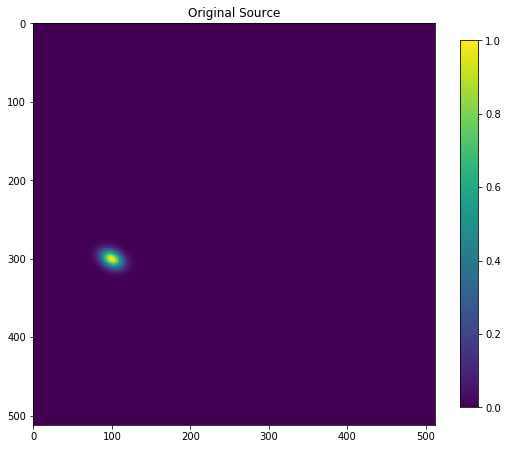

In [32]:
imgSize = 512
sizeScale = 33.
xpos, ypos = np.mgrid[0:imgSize, 0:imgSize].astype(float) #make a grid of pixel indicies

gFunc = generalGauss2d(300, 100, 7., 10., amp=1., theta=sizeScale)
trueSignal = gFunc(xpos, ypos)

fig = plt.figure(figsize=(9, 9))
plt.imshow(trueSignal)
plt.colorbar(shrink=0.75)
plt.title('Original Source')

*Figure: 2-D Gaussian source*

Noise is added to the image to set the signal to noise of the source to be 0.3, well below the typical detection threshold of an observation.

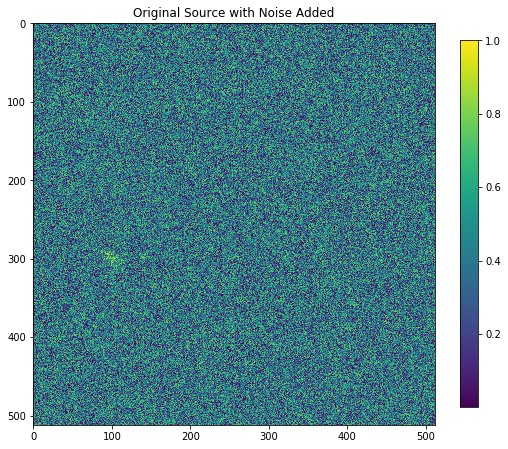

In [40]:
SNR = 0.3
noisySignal = trueSignal + (1./SNR) * np.random.rand(trueSignal.shape[0], trueSignal.shape[1])
fig = plt.figure(figsize=(9, 9))
plt.imshow(noisySignal/np.max(noisySignal))
plt.colorbar(shrink=0.75)
plt.title('Original Source with Noise Added')

*Figure: Noisy image with a SNR=0.3 2-D Gaussian source.*

Now, since we know the shape and size of the original source we construct a matched filter. It is important to notice that the template is in the centre of matched filter image. Since we are doign a convolution we do not need to know the location of the original source.

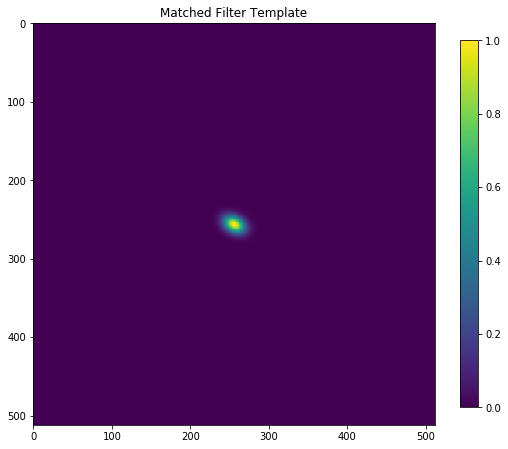

In [41]:
gFunc1 = generalGauss2d(imgSize/2., imgSize/2., 7., 10., amp=1., theta=33.)
matchedFilter = gFunc1(xpos, ypos)
fig = plt.figure(figsize=(9, 9))
plt.imshow(matchedFilter)
plt.colorbar(shrink=0.75)
plt.title('Matched Filter Template')

*Figure: A matched filter for the original source.*

Applying the matched filter is done by convolving the template with the noisy image. Recall this convolution can be performed efficiently using the [convolution theorem &#10142;](../2_Mathematical_Groundwork/2_7_fourier_theorems.ipynb).

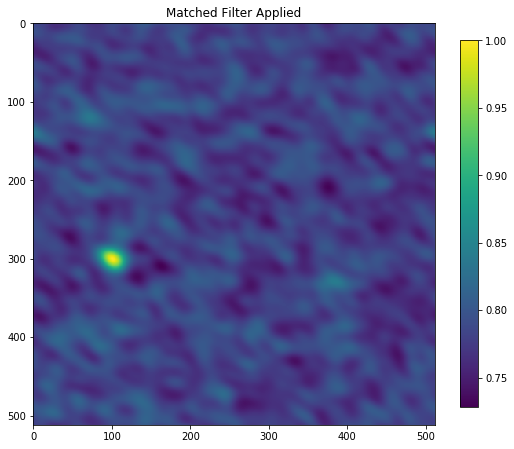

In [42]:
filteredSignal = np.fft.ifft2(np.fft.fft2(np.fft.fftshift(matchedFilter)) * np.fft.fft2(noisySignal)).real
fig = plt.figure(figsize=(9, 9))
plt.imshow(filteredSignal/np.max(filteredSignal))
plt.colorbar(shrink=0.75)
plt.title('Matched Filter Applied')

*Figure: the resulting image after a well-mateched filter has been applied.*

Even though we added noise to give the source an SNR of 0.3, with a well matched filter applied, the source is seen clearly, and is well above the noise of the rest of the image.

***

### 5.A.2 Example: Un-matched Filter

It is often the case we do not know the exact size, shape, or orientation of a source. But, we can still used matched filtering to get approxiamtely maximal SNR solutions.

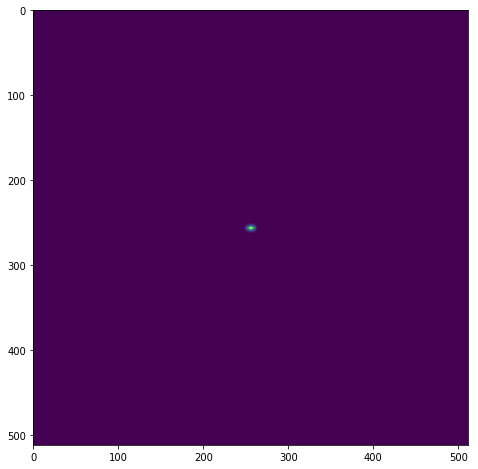

In [8]:
gFunc1 = generalGauss2d(imgSize/2., imgSize/2., 2., 3., amp=1., theta=0.)
matchedFilter = gFunc1(xpos, ypos)
fig = plt.figure(figsize=(8, 8))
plt.imshow(matchedFilter)

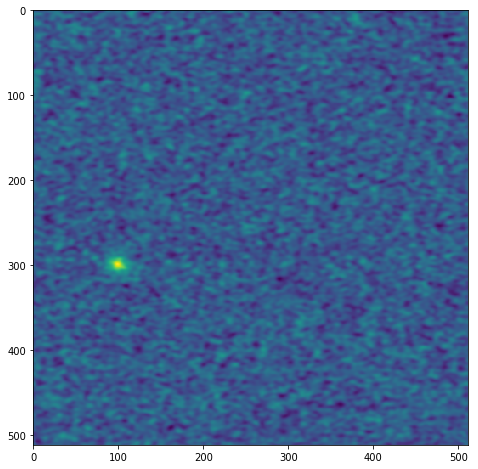

In [9]:
filteredSignal = np.fft.ifft2(np.fft.fft2(np.fft.fftshift(matchedFilter)) * np.fft.fft2(noisySignal)).real
fig = plt.figure(figsize=(8, 8))
plt.imshow(filteredSignal)

***

### Multiple Sources

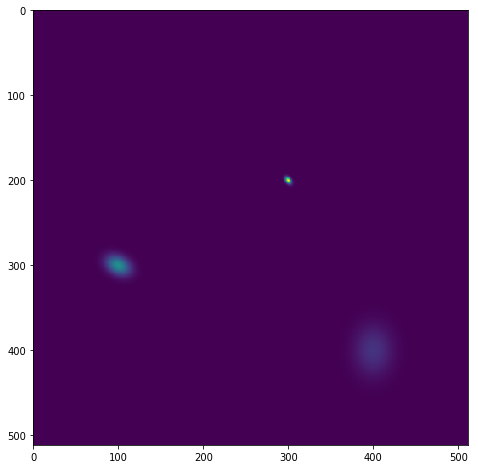

In [10]:
gFunc = generalGauss2d(300, 100, 7., 10., amp=1., theta=33.)
trueSignal = gFunc(xpos, ypos)

gFunc = generalGauss2d(400, 400, 20., 15., amp=.3, theta=0)
trueSignal += gFunc(xpos, ypos)

gFunc = generalGauss2d(200, 300, 2., 3., amp=2., theta=45.)
trueSignal += gFunc(xpos, ypos)

fig = plt.figure(figsize=(8, 8))
plt.imshow(trueSignal)

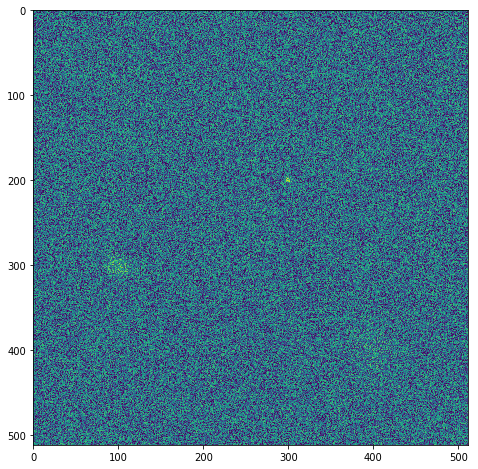

In [11]:
SNR = 0.3
noisySignal = trueSignal + (1./SNR) * np.random.rand(trueSignal.shape[0], trueSignal.shape[1])
fig = plt.figure(figsize=(8, 8))
plt.imshow(noisySignal)

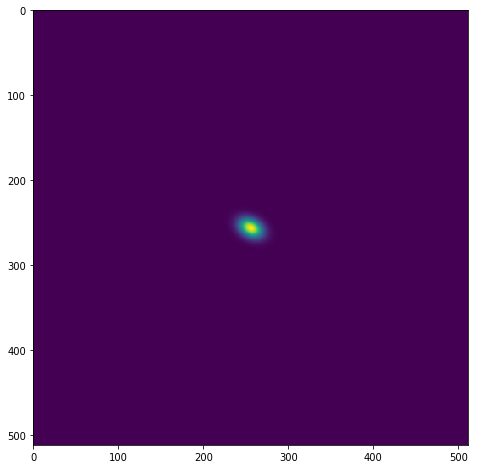

In [12]:
gFunc1 = generalGauss2d(imgSize/2., imgSize/2., 7, 10., amp=1., theta=33.)
matchedFilter = gFunc1(xpos, ypos)
fig = plt.figure(figsize=(8, 8))
plt.imshow(matchedFilter)

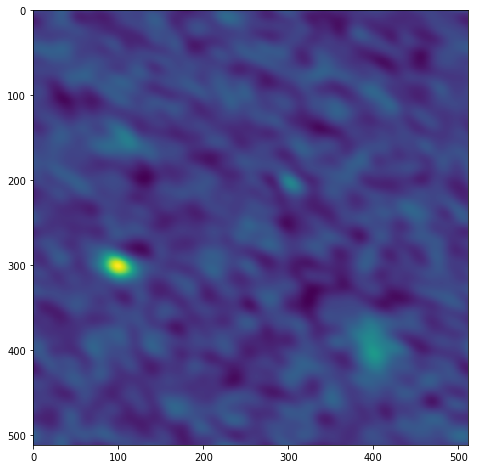

In [13]:
filteredSignal = np.fft.ifft2(np.fft.fft2(np.fft.fftshift(matchedFilter)) * np.fft.fft2(noisySignal)).real
fig = plt.figure(figsize=(8, 8))
plt.imshow(filteredSignal)

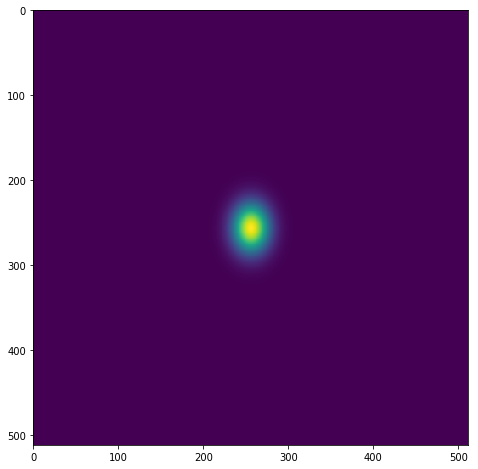

In [14]:
gFunc1 = generalGauss2d(imgSize/2., imgSize/2., 20., 15., amp=.3, theta=0)
matchedFilter = gFunc1(xpos, ypos)
fig = plt.figure(figsize=(8, 8))
plt.imshow(matchedFilter)

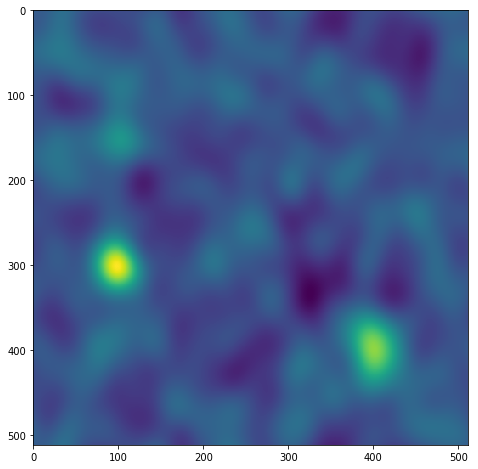

In [15]:
filteredSignal = np.fft.ifft2(np.fft.fft2(np.fft.fftshift(matchedFilter)) * np.fft.fft2(noisySignal)).real
fig = plt.figure(figsize=(8, 8))
plt.imshow(filteredSignal)

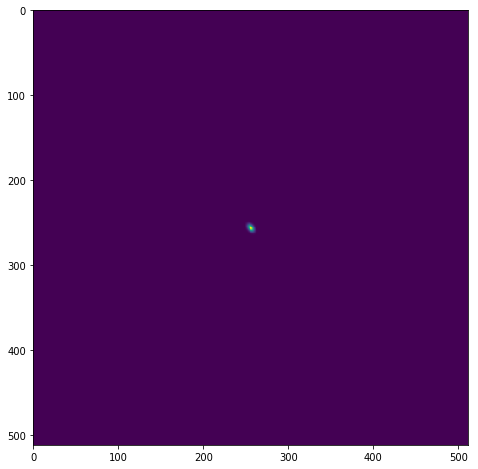

In [16]:
gFunc1 = generalGauss2d(imgSize/2., imgSize/2., 2., 3., amp=2., theta=45.)
matchedFilter = gFunc1(xpos, ypos)
fig = plt.figure(figsize=(8, 8))
plt.imshow(matchedFilter)

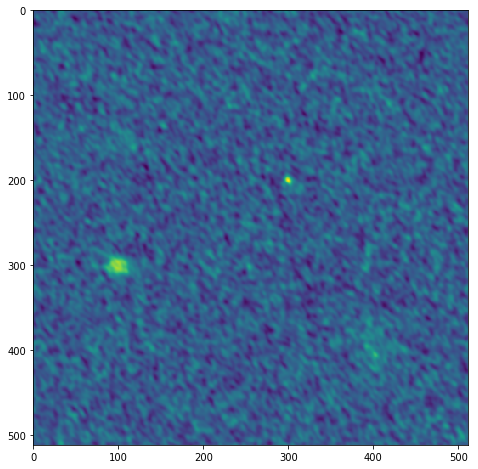

In [17]:
filteredSignal = np.fft.ifft2(np.fft.fft2(np.fft.fftshift(matchedFilter)) * np.fft.fft2(noisySignal)).real
fig = plt.figure(figsize=(8, 8))
plt.imshow(filteredSignal)

***